In [148]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt


In [149]:
def create_kernels(X_train, y_train, kernel):

    one_vs_one = svm.SVC(kernel=kernel, decision_function_shape='ovo').fit(X_train, y_train)
    one_vs_rest = svm.SVC(kernel=kernel, decision_function_shape='ovr').fit(X_train, y_train)

    return one_vs_one, one_vs_rest

def get_support_vectors_for_each_class(one_vs_one, one_vs_rest):
    ovo_sv = {}
    ovr_sv = {}
    for i in range(len(one_vs_one.classes_)):
        ovo_sv[one_vs_one.classes_[i]] = one_vs_one.support_vectors_[one_vs_one.n_support_[i]:]
        ovr_sv[one_vs_rest.classes_[i]] = one_vs_rest.support_vectors_[one_vs_rest.n_support_[i]:]

    return ovo_sv, ovr_sv

def train_and_predict(kernels, X_train, X_test, y_train, y_test):
    kernels_dict = {kernel: {"ovo": {}, "ovr": {}} for kernel in kernels}
    for kernel in kernels:
        one_vs_one, one_vs_rest = create_kernels(X_train, y_train, kernel)

        ovo_y_pred = one_vs_one.predict(X_test)
        ovo_accuracy = metrics.accuracy_score(y_test, ovo_y_pred)
        ovo_confusion_matrix = metrics.confusion_matrix(y_test, ovo_y_pred)
        ovo_f1_score = metrics.f1_score(y_test, ovo_y_pred, average='weighted')

        ovr_y_pred = one_vs_rest.predict(X_test)
        ovr_accuracy = metrics.accuracy_score(y_test, ovr_y_pred)
        ovr_confusion_matrix = metrics.confusion_matrix(y_test, ovr_y_pred)
        ovr_f1_score = metrics.f1_score(y_test, ovr_y_pred, average='weighted')

        ovo_sv, ovr_sv = get_support_vectors_for_each_class(one_vs_one, one_vs_rest)

        kernels_dict[kernel]["ovo"] = {"kernel": one_vs_one, "accuracy": ovo_accuracy, "confusion_matrix": ovo_confusion_matrix, "f1_score": ovo_f1_score, "support_vectors": ovo_sv}
        kernels_dict[kernel]["ovr"] = {"kernel": one_vs_rest, "accuracy": ovr_accuracy, "confusion_matrix": ovr_confusion_matrix, "f1_score": ovr_f1_score, "support_vectors": ovr_sv}
    
    return kernels_dict


def print_kernel_details(kernels):
    for kernel in kernels.keys():
        print(f"Kernel: {kernel}")
        print(f"OVO Accuracy: {kernels[kernel]['ovo']['accuracy']}")
        print(f"OVO F1 Score: {kernels[kernel]['ovo']['f1_score']}")
        print("\n")
        print(f"OVR Accuracy: {kernels[kernel]['ovr']['accuracy']}")
        print(f"OVR F1 Score: {kernels[kernel]['ovr']['f1_score']}")
        print("\n")
        print(f"OVO Confusion Matrix: \n{kernels[kernel]['ovo']['confusion_matrix']}")
        print(f"OVR Confusion Matrix: \n{kernels[kernel]['ovr']['confusion_matrix']}")
        print("\n")
        for i in range(len(kernels[kernel]['ovr']['support_vectors'])):
            print(f"Class {i} OVR Support Vectors: \n{kernels[kernel]['ovr']['support_vectors'][i]}")
            print("\n")
        print("###################################################################################")
        print("\n\n")

def get_best_f1_and_accuracy(kernels):
    best_f1 = 0
    best_accuracy = 0
    best_f1_kernel = None
    best_f1_function = None
    best_accuracy_kernel = None
    best_accuracy_function = None
    for kernel in kernels.keys():
        for function in kernels[kernel].keys():
            if kernels[kernel]["ovo"]['f1_score'] > best_f1:
                best_f1 = kernels[kernel]["ovo"]['f1_score']
                best_f1_kernel = kernel
                best_f1_function = "ovo"
            if kernels[kernel]["ovr"]['accuracy'] > best_accuracy:
                best_accuracy = kernels[kernel]["ovr"]['accuracy']
                best_accuracy_kernel = kernel
                best_accuracy_function = "ovr"

    return best_f1_kernel, best_f1_function, best_accuracy_kernel, best_accuracy_function, best_f1, best_accuracy

def plot_decision_boundaries(model, X, y_train, indices, title):
    
    x_min, x_max = X[:, indices[0]].min() - 1, X[:, indices[0]].max() + 1
    y_min, y_max = X[:, indices[1]].min() - 1, X[:, indices[1]].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    data = np.c_[xx.ravel(), yy.ravel()]

    
    Z = model.predict(data)
    Z = Z.reshape(xx.shape)

    plt.gca()
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, indices[0]], X[:, indices[1]], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.xlabel(f'Feature {indices[0]}')
    plt.ylabel(f'Feature {indices[1]}')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)

def plot_all_decision_boundaries(kernels, X_train, y_train):
    plt.figure(figsize=(20, 10))
    for i, kernel in enumerate(kernels.keys()):
        plt.subplot(2, 3, i + 1)
        title = f"Kernel: {kernel} with features 2 vs 3"
        indices = [1,2]
        X_train_subset = X_train[:, indices]
        one_vs_one = svm.SVC(kernel=kernel, decision_function_shape='ovo').fit(X_train_subset, y_train)
        plot_decision_boundaries(one_vs_one, X_train, y_train, indices, title)

    for i, kernel in enumerate(kernels.keys()):
        plt.subplot(2, 3, i + 4)
        title = f"Kernel: {kernel} with features 3 vs 4"
        indices = [2,3]
        X_train_subset = X_train[:, indices]
        one_vs_one = svm.SVC(kernel=kernel, decision_function_shape='ovo').fit(X_train_subset, y_train)
        plot_decision_boundaries(one_vs_one, X_train, y_train, indices, title)
        
    plt.tight_layout()
    plt.show()


In [150]:
iris = datasets.load_iris()

# Assuming 'data' is your feature matrix and 'target' is your label vector
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.2, train_size=0.8, random_state=56) # random_state for replicating same results

kernels = ['linear', 'poly', 'rbf']

kernels_dict = train_and_predict(kernels, X_train, X_test, y_train, y_test)

print_kernel_details(kernels_dict)




Kernel: linear
OVO Accuracy: 0.9666666666666667
OVO F1 Score: 0.9665831244778613


OVR Accuracy: 0.9666666666666667
OVR F1 Score: 0.9665831244778613


OVO Confusion Matrix: 
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
OVR Confusion Matrix: 
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


Class 0 OVR Support Vectors: 
[[6.3 2.5 4.9 1.5]
 [6.8 2.8 4.8 1.4]
 [5.9 3.2 4.8 1.8]
 [5.4 3.  4.5 1.5]
 [6.9 3.1 4.9 1.5]
 [6.3 3.3 4.7 1.6]
 [6.5 2.8 4.6 1.5]
 [5.  2.3 3.3 1. ]
 [6.  2.9 4.5 1.5]
 [5.6 3.  4.5 1.5]
 [5.7 2.8 4.5 1.3]
 [6.2 2.8 4.8 1.8]
 [4.9 2.5 4.5 1.7]
 [7.2 3.  5.8 1.6]
 [6.5 3.  5.2 2. ]
 [6.  3.  4.8 1.8]
 [6.3 2.7 4.9 1.8]
 [5.9 3.  5.1 1.8]
 [6.3 2.8 5.1 1.5]
 [6.  2.2 5.  1.5]
 [6.5 3.2 5.1 2. ]]


Class 1 OVR Support Vectors: 
[[6.  2.9 4.5 1.5]
 [5.6 3.  4.5 1.5]
 [5.7 2.8 4.5 1.3]
 [6.2 2.8 4.8 1.8]
 [4.9 2.5 4.5 1.7]
 [7.2 3.  5.8 1.6]
 [6.5 3.  5.2 2. ]
 [6.  3.  4.8 1.8]
 [6.3 2.7 4.9 1.8]
 [5.9 3.  5.1 1.8]
 [6.3 2.8 5.1 1.5]
 [6.  2.2 5.  1.5]
 [6.5 3.2 5.1 2. ]]


Class 2 OVR Sup

In [151]:
best_f1_kernel, best_f1_function, best_accuracy_kernel, best_accuracy_function, best_f1, best_accuracy = get_best_f1_and_accuracy(kernels_dict)

print(f"Best F1 Score: {best_f1}")
print(f"Best F1 Kernel: {best_f1_kernel}")
print(f"Best F1 Function: {best_f1_function}")
print("\n")

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Accuracy Kernel: {best_accuracy_kernel}")
print(f"Best Accuracy Function: {best_accuracy_function}")
print("\n")

Best F1 Score: 0.9665831244778613
Best F1 Kernel: linear
Best F1 Function: ovo


Best Accuracy: 0.9666666666666667
Best Accuracy Kernel: linear
Best Accuracy Function: ovr




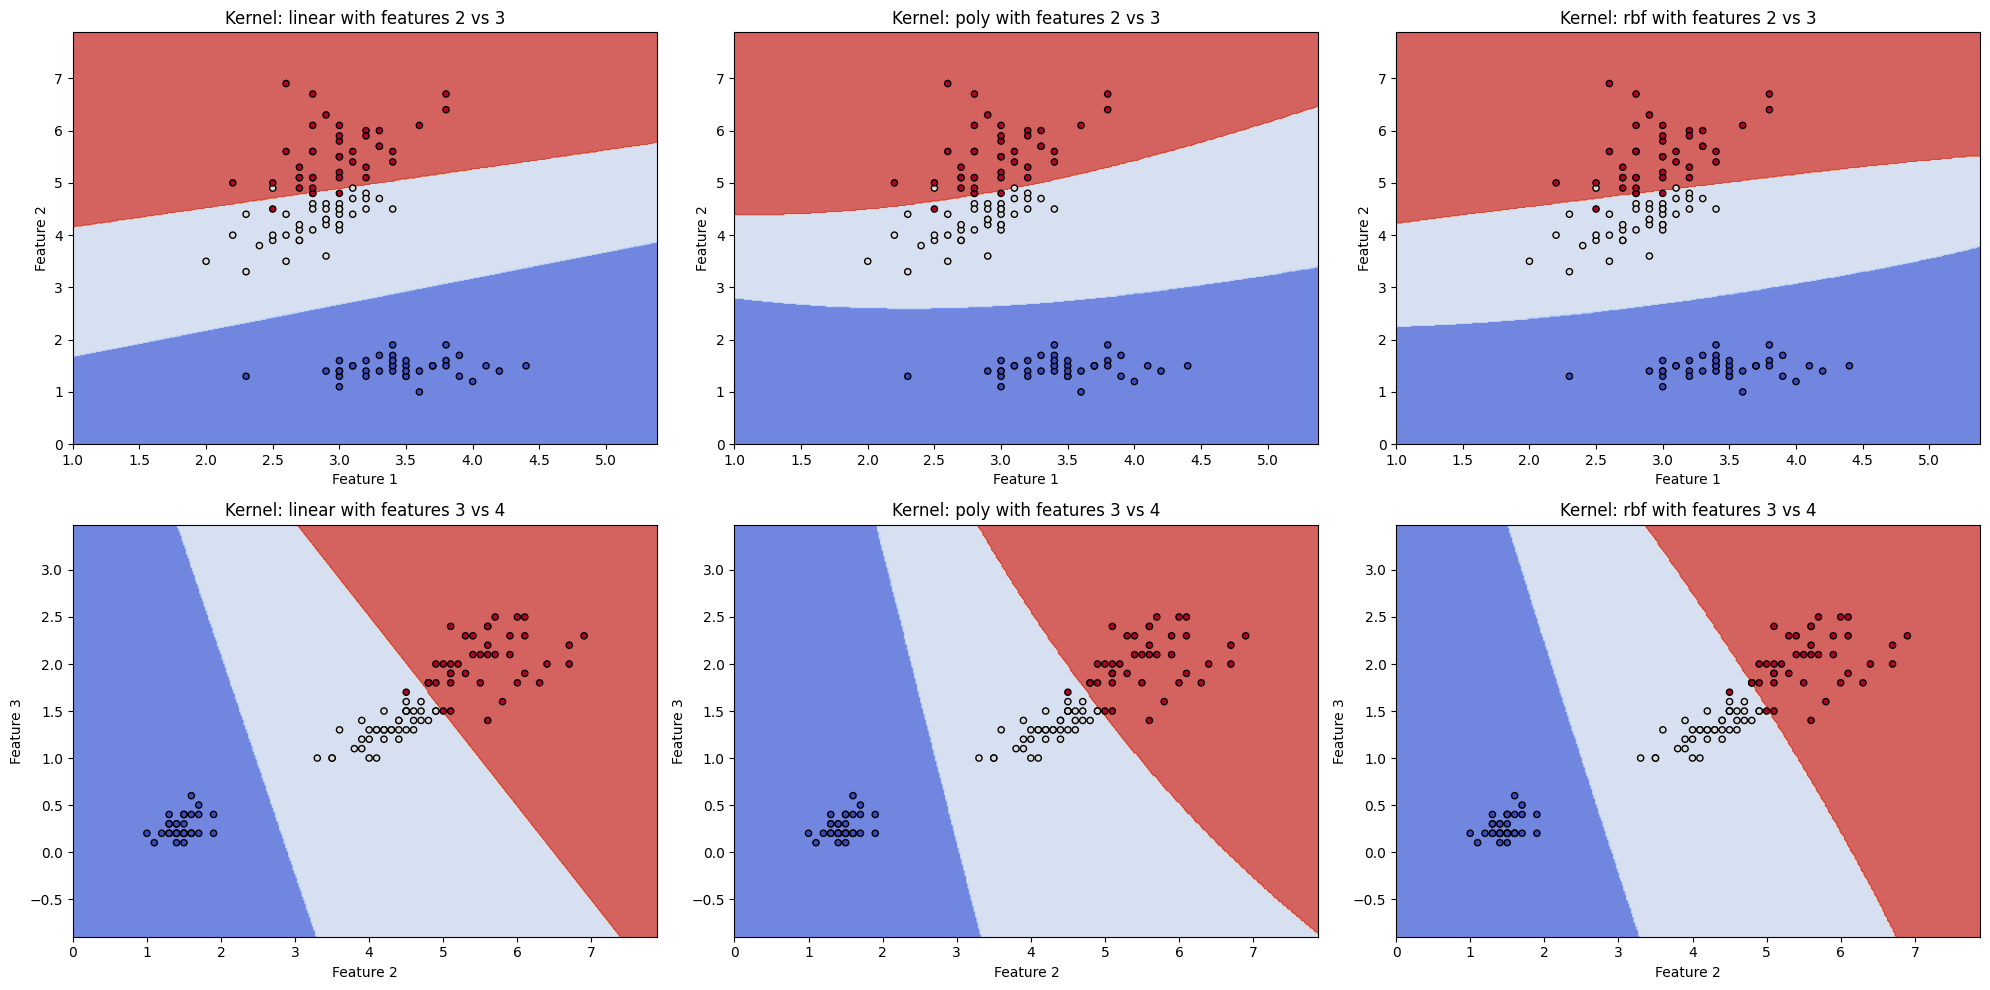

In [152]:
plot_all_decision_boundaries(kernels_dict, X_train, y_train)